In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn
from pyneb import config, log_, atomicData
from pyneb.utils.misc import parseAtom
pn.config.use_multiprocs()
from astropy.io import fits
from astropy.wcs import WCS
from pathlib import Path

In [64]:
%load_ext autoreload
%aimport pipeline
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
l_dic = {'4641.0': ('N', 2, '4641A', 1),
         '4651.0' : ('O', 2, '4649A', 1),
         '4659.0' : ('Fe', 3, '4659A', 0),
         '4662.0' : ('O', 2, '4662A', 1),
         '4686.0' : ('He', 2, '4686A', 1),
         '4711.0' : ('Ar', 4, '4711A', 0),
         '4713.0' : ('He', 1, '4713A', 1),
         '4741.0' : ('Ar', 4, '4740A', 0),
         '4861.0' : ('H', 1, '4861A', 1)
         '4959.0' : ('O', 3, '4959A', 0),
         '5200.0' : ('N', 1, '5200A', 0),
         '5343.0' : ('C', 2, '5342A', 1),,
         '5519.0' : ('Cl', 3, '5518A', 0),
         '5539.0' : ('Cl', 3, '5538A', 0),
         '5677' : ('N', 2, '5676A', 1),
         '5681.0' : ('N', 2, '5679A', 1),
         '5755.0' : ('N', 2, '5755A', 0),
         '5877' : ('He', 1, '5876A', 1),
         '6301.0' : ('O', 1, '6300A', 0),
         '6313' : ('S', 3, '6312A', 0),
         '6365.0' : ('O', 1, '6364A', 0),
         '6463.0' : ('C', 2, '6461A', 0),
         '6549.0' : ('N', 2, '6548A', 0),
         '6564.0' : ('H', 1, '6563A', 1),
         '6585.0' : ('N', 2, '6584A', 0),
         '6679.0' : ('He', 1, '6678A', 1),
         '6719.0' : ('S', 2, '6716A', 0),
         '6733.0' : ('S', 2, '6731A', 0),
         '7002' : ('O', 4, '7004A', 0),
         '7006.0' : ('Ne', 5, '7005A', 0),
         '7067.0' : ('He', 1, '7065A', 1),
         '7137.0' : ('Ar', 3, '7136A', 0),
         '7321.0' : ('O', 2, '7320A', 0),
         '7332.0' : ('O', 2, '7330A', 0),
         '7532.0' : ('Cl', 4, '7531A', 0),
         '7753.0' : ('Ar', 3, '7751A', 0),
         '7772.0' : ('O', 1, '7771A', 1),
         '7774.0' : ('O', 1, '7773A', 1),
         '7777' : ('O', 1, '7775A', 1),
         '8048.0' : ('Cl', 4, '8046A', 0),
         '8730.0' : ('C', 1, '8728A', 0),
         '8736.0' : ('He', 1, '8733A', 1),
         '8753.0' : ('H', 1, '8750A', 1), 
         '9071.0' : ('S', 3, '9069A', 0)
         }

In [4]:
obs = pn.Observation(corrected = False)
for lam_str in l_dic:
    l = l_dic[lam_str]
    data_file = data_dir / Path('ngc6778_MUSE_{}.fits'.format(lam_str))
    fits_hdu = fits.open(data_file)[0]
    fits_data = fits_hdu.data
    err_data_file = data_dir / Path('ngc6778_MUSE_{}_error.fits'.format(lam_str))
    err_fits_hdu = fits.open(err_data_file)[0]
    err_fits_data = err_fits_hdu.data
    if l[3] == 1:
        perm = 'r'
    else:
        perm = ''
    label='{}{}{}_{}'.format(l[0], l[1], perm, l[2])
    line = pn.EmissionLine( label=label,
                           obsIntens=fits_data.ravel(), 
                           obsError=err_fits_data.ravel(), 
                           corrected=False, errIsRelative=False)
    obs.addLine(line)
wcs = WCS(fits_hdu.header).celestial
obs.names = ['N{}N'.format(i) for i in range(obs.n_obs)]

warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 4649A for atom O2r not valid
warng EmissionLine: line 4662A for atom O2r not valid
warng EmissionLine: Atom C2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 6461A for atom C2 not valid
warng EmissionLine: line 7004A for atom O4 not valid
warng EmissionLine: line 7005A for atom Ne5 not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: line 8733A for atom He1r not valid
warng EmissionLine: line 8750A for atom H1r not valid


In [5]:
pn.log_.level=3
pn.log_.timer('Starting', quiet=True)
obs.addMonteCarloObs(50)
pn.log_.timer('Ending MC')

     addMonteCarloObs: Entering
     addMonteCarloObs: Leaving
   None: Ending MC in 2.6423442363739014


In [6]:
obs.def_EBV()

/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/extinction/red_corr.py:299: RuntimeWarning: invalid value encountered in log10
  self.E_BV = 2.5 * np.log10(obs_over_theo) / (f1 - f2)


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


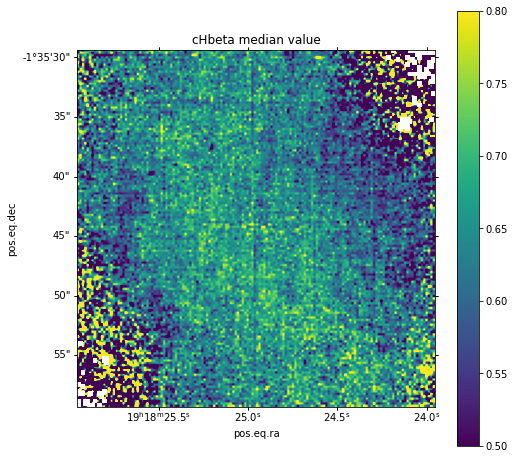

In [7]:
c_Hbeta = obs.extinction.cHbeta.reshape((150, 150, 51))
f, ax = plt.subplots(subplot_kw={'projection': wcs}, figsize=(8,8))
im = ax.imshow(np.nanmedian(c_Hbeta, 2), vmin=0.5, vmax=.8)
cb = f.colorbar(im, ax=ax)
ax.set_title('cHbeta median value');

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


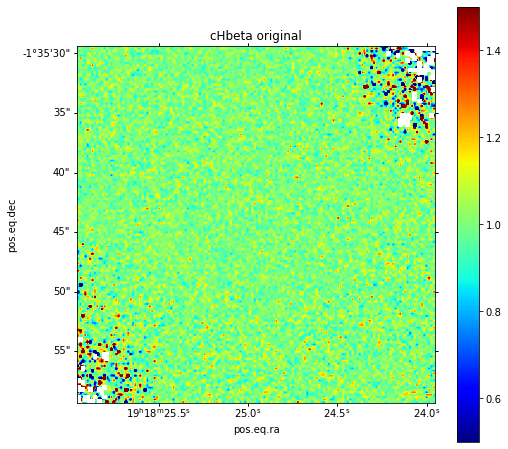

In [8]:
c_Hbeta_0 = obs.extinction.cHbeta.reshape((150, 150, 51))[:, :, 0]
f, ax = plt.subplots(subplot_kw={'projection': wcs}, figsize=(8,8))
im = ax.imshow(c_Hbeta_0 / np.nanmedian(c_Hbeta, 2), vmin=0.5, vmax=1.5, cmap='jet')
cb = f.colorbar(im, ax=ax)
ax.set_title('cHbeta original');

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


0.6290392049046702


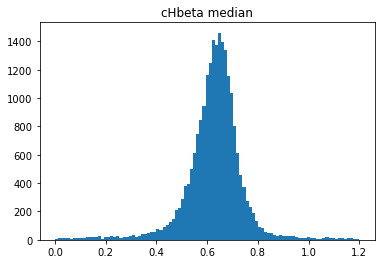

In [9]:
f, ax = plt.subplots()
ax.hist(np.nanmedian(c_Hbeta, 2).ravel(), bins=np.linspace(0, 1.2, 100))
ax.set_title('cHbeta median')
print(np.nanmedian(c_Hbeta));

In [10]:
obs.correctData()

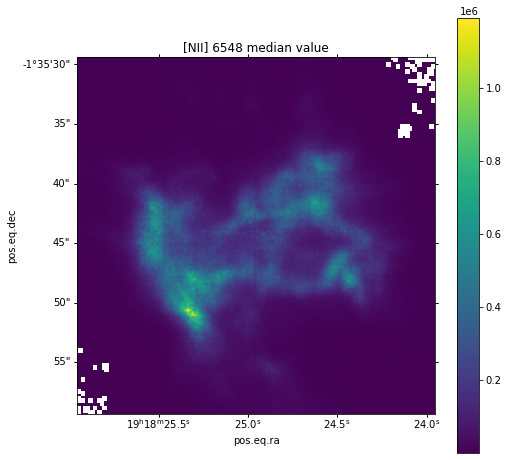

In [11]:
f, ax = plt.subplots(subplot_kw={'projection': wcs}, figsize=(8,8))
im=ax.imshow(np.nanmedian(obs.getIntens()['N2_6548A'].reshape(150,150,51), 2))
cb = f.colorbar(im, ax=ax)
ax.set_title('[NII] 6548 median value');

In [12]:
obs.n_obs

1147500

In [13]:
pn.log_.level=2
diags = pn.Diagnostics()
diags.ANN_inst_kwargs['verbose']=True
diags.addDiagsFromObs(obs)

warng Observation: No line for O2_3727A+ from NoneNone at wavelength None (blend=False)


In [14]:
diags.diags

{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SIII] 6312/9069': ('S3', 'L(6312)/L(9069)', 'RMS([E(9069), E(6312)])'),
 '[ClIII] 5538/5518': ('Cl3', 'L(5538)/L(5518)', 'RMS([E(5518), E(5538)])'),
 '[ArIV] 4740/4711': ('Ar4', 'L(4740)/L(4711)', 'RMS([E(4711), E(4740)])')}

In [15]:
pn.log_.timer('Starting', quiet=True)
pn.log_.level = 3
Te_N284, Ne_S2_b = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', obs=obs, use_ANN=True)
print('-----------')
Te_N2, Ne_S2 = diags.getCrossTemDen('[NII] 5755/6548', '[SII] 6731/6716', obs=obs, use_ANN=True)
print('-----------')
Te_S3_cl3, Ne_Cl3 = diags.getCrossTemDen('[SIII] 6312/9069', '[ClIII] 5538/5518', obs=obs, use_ANN=True)
print('-----------')
Te_S3_s2, Ne_S2_c = diags.getCrossTemDen('[SIII] 6312/9069', '[SII] 6731/6716', obs=obs, use_ANN=True)
pn.log_.timer('ANN getCrossTemDen done')

Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
(900, 2) (900, 2)
RM trained, with 4911 iterations. Score = 0.999
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             solver='lbfgs')
Training time 6.3 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1048184


/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:541: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


Predicting from 2 inputs to 2 outputs using 1048184 data in 0.75 secs.
-----------
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
(900, 2) (900, 2)
RM trained, with 5153 iterations. Score = 0.998
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             solver='lbfgs')
Training time 7.1 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1048070


/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:541: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


Predicting from 2 inputs to 2 outputs using 1048070 data in 0.75 secs.
-----------
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
(900, 2) (900, 2)
RM trained, with 2206 iterations. Score = 1.000
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             solver='lbfgs')
Training time 2.9 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 861133


/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:541: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


Predicting from 2 inputs to 2 outputs using 861133 data in 0.59 secs.
-----------
Instantiation. V 0.17
Training set size = 900, Test set size = 0
Train data scaled. Log10 applied. 
Test data scaled. 
Training set size = 900, Test set size = 0
Training set size = 900, Test set size = 0
Regression Model SK_ANN
Training 2 inputs for 2 outputs with 900 data
(900, 2) (900, 2)
RM trained, with 11654 iterations. Score = 0.999
MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=20000,
             solver='lbfgs')
Training time 15.4 s.
Test data scaled. Log10 applied. 
Training set size = 900, Test set size = 1027581


/Users/christophemorisset/Google Drive/Pro/AI4neb/ai4neb/Regressor/RegressionModel.py:541: RuntimeWarning: invalid value encountered in log10
  X = np.log10(X)


Predicting from 2 inputs to 2 outputs using 1027581 data in 0.73 secs.
   None: ANN getCrossTemDen done in 38.01171922683716


In [17]:
Te_N2 = np.reshape(Te_N2, (150, 150, 51))
Ne_S2 = np.reshape(Ne_S2, (150, 150, 51))
Te_S3_s2 = np.reshape(Te_S3_s2, (150, 150, 51))
Ne_Cl3 = np.reshape(Ne_Cl3, (150, 150, 51))

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


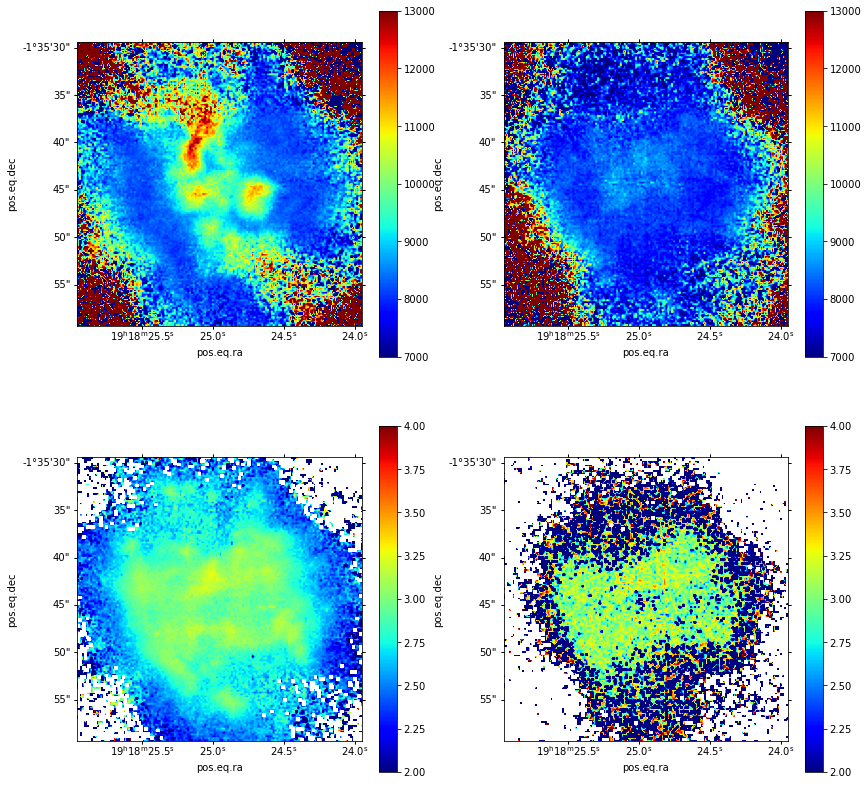

In [18]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={'projection': wcs}, figsize=(14,14))
im1 = ax1.imshow(np.median(Te_N2, 2), vmin=7000, vmax=13000, cmap='jet')
cb1 = f.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.median(Te_S3_s2, 2), vmin=7000, vmax=13000, cmap='jet')
cb2 = f.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.log10(np.median(Ne_S2, 2)), vmin=2, vmax=4, cmap='jet')
cb3 = f.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.log10(np.median(Ne_Cl3, 2)), vmin=2, vmax=4, cmap='jet')
cb4 = f.colorbar(im4, ax=ax4)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


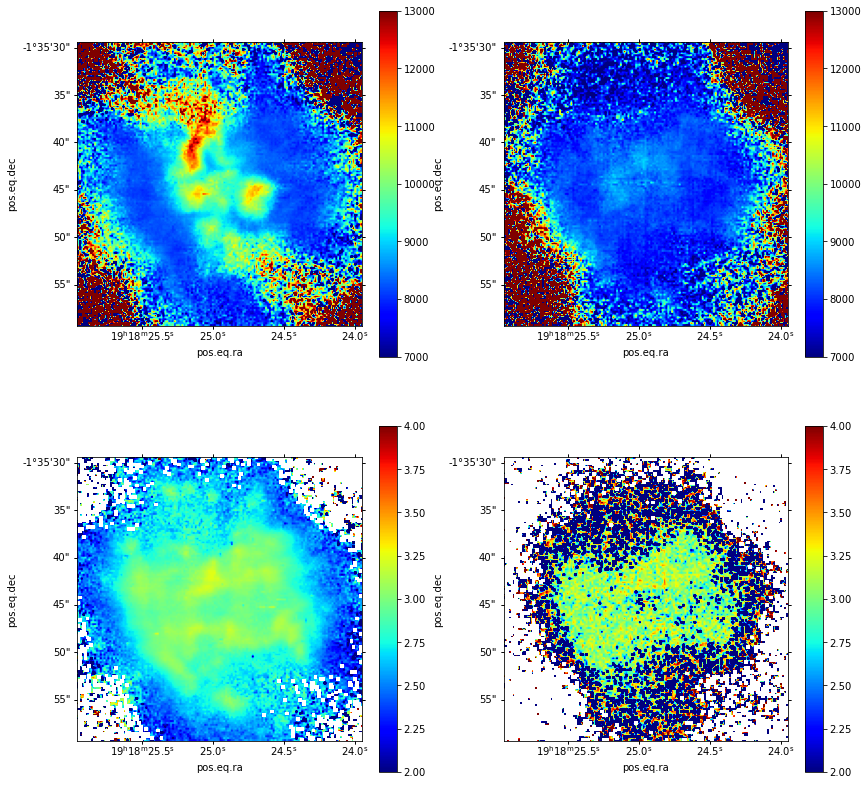

In [20]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={'projection': wcs}, figsize=(14,14))
im1 = ax1.imshow(Te_N2[:,:,0], vmin=7000, vmax=13000, cmap='jet')
cb1 = f.colorbar(im1, ax=ax1)
im2 = ax2.imshow(Te_S3_s2[:,:,0], vmin=7000, vmax=13000, cmap='jet')
cb2 = f.colorbar(im2, ax=ax2)
im3 = ax3.imshow(np.log10(Ne_S2[:,:,0]), vmin=2, vmax=4, cmap='jet')
cb3 = f.colorbar(im3, ax=ax3)
im4 = ax4.imshow(np.log10(Ne_Cl3[:,:,0]), vmin=2, vmax=4, cmap='jet')
cb4 = f.colorbar(im4, ax=ax4)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


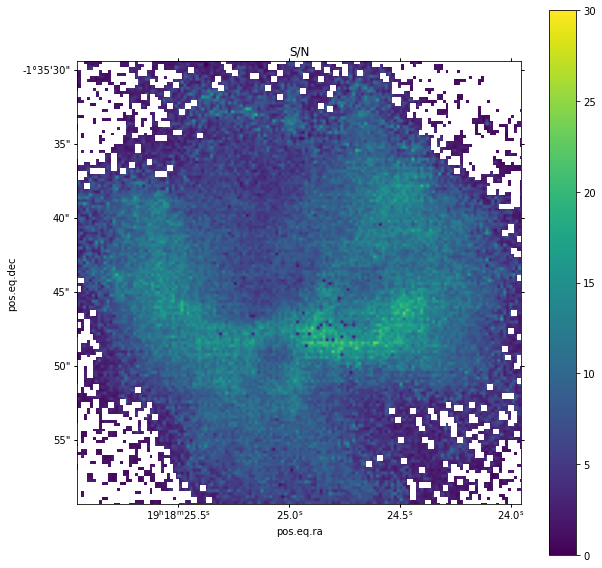

In [21]:
f, ax = plt.subplots(subplot_kw={'projection': wcs}, figsize=(8,8))
im=ax.imshow(np.nanmedian(Te_N2, 2)/np.nanstd(Te_N2, 2), vmin=0,vmax=30)
ax.set_title('S/N')
cb = f.colorbar(im, ax=ax)
f.tight_layout();

In [115]:
PL = pipeline.PipeLine()
PL.add_MC(50)
PL.red_cor_obs(plot_=False)

warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 4649A for atom O2r not valid
warng EmissionLine: line 4662A for atom O2r not valid
warng EmissionLine: Atom C2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 6461A for atom C2 not valid
warng EmissionLine: line 7004A for atom O4 not valid
warng EmissionLine: line 7005A for atom Ne5 not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: line 8733A for atom He1r not valid
warng EmissionLine: line 8750A for atom H1r not valid
     addMonteCarloObs: Entering
     addMonteCarloObs: Leaving


/Users/christophemorisset/Google Drive/Pro/PyNeb_devel/pyneb/extinction/red_corr.py:299: RuntimeWarning: invalid value encountered in log10
  self.E_BV = 2.5 * np.log10(obs_over_theo) / (f1 - f2)


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


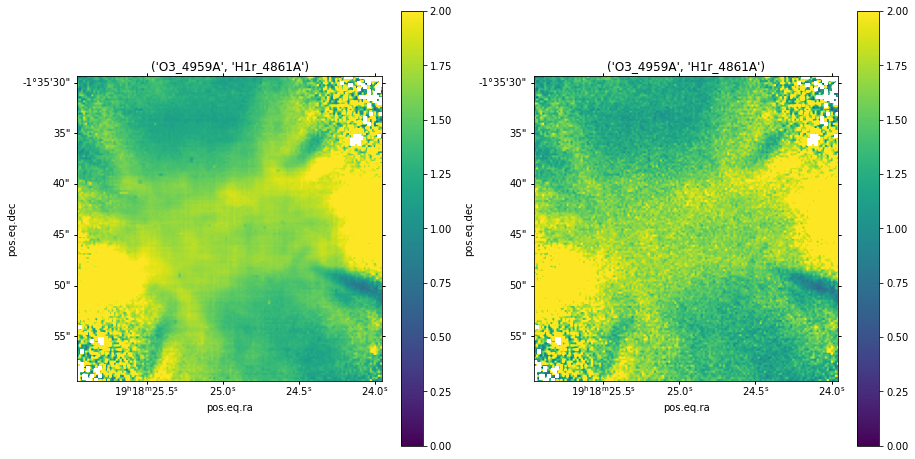

In [136]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': PL.wcs})
PL.plot(ax=ax1, label=('O3_4959A', 'H1r_4861A'), type_='orig', vmax=2)
PL.plot(ax=ax2, label=('O3_4959A', 'H1r_4861A'), type_='median', vmax=2)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


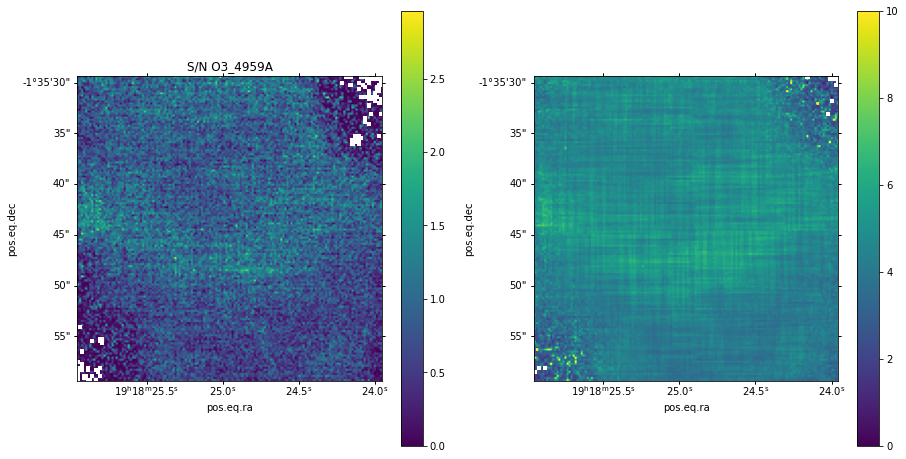

In [143]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': PL.wcs})
PL.plot_SN(label='O3_4959A', ax=ax1)
im2 = ax2.imshow(1./PL.get_image(PL.obs.getError()['O3_4959A'], type_='orig'), vmin=0,vmax=10.)
cb2 = f.colorbar(im2, ax=ax2)

In [156]:
x = 80
y = 80
std1 = np.std(PL.obs.getIntens(returnObs=True)['O3_4959A'].reshape(150,150,51)[x,y])
med1 = np.median(PL.obs.getIntens(returnObs=True)['O3_4959A'].reshape(150,150,51)[x,y])
err1 = PL.obs.getError(returnObs=True)['O3_4959A'].reshape(150,150,51)[x,y, 1]
std2 = np.std(PL.obs.getIntens(returnObs=False)['O3_4959A'].reshape(150,150,51)[x,y])
med2 = np.median(PL.obs.getIntens(returnObs=False)['O3_4959A'].reshape(150,150,51)[x,y])
err2 = PL.obs.getError(returnObs=False)['O3_4959A'].reshape(150,150,51)[x,y, 1]
print(med1/std1, med2/std2, med1, med2, std1, std2)
print(1./err1,1./err2)

4.713116468835047 0.5190449005238588 140388.8943947017 552603.5007668668 29786.850234448375 1064654.522583958
5.416385459564256 5.416385459564256


In [222]:
print((PL.obs.getIntens(returnObs=False)['O3_4959A'] / PL.obs.getIntens(returnObs=True)['O3_4959A']).reshape(150,150,51)[x,y])

[ 3.89161733  7.3109642   1.26449469  5.60485549  6.40749126  1.34192268
  1.39396473  3.89272417  5.71733187  2.48282855  3.07500953  4.59448933
  6.53768806  2.02546532 14.30683075  3.85633845  4.67296176 11.3627486
  1.78782206  2.11043278  3.79021731  5.68017939  2.54422153  3.71342482
  2.58268547  2.18919416  6.39264742  1.35335371  7.59424264  3.77291763
  4.62738544  4.16174    40.08365811  5.86452197  3.92716512  2.5939147
  2.28003465  4.50635709 28.68674553  5.50382679  9.22518105  4.40992701
  3.74133538  1.88002696  2.9358882   3.77315499  3.81974574  1.61513711
 13.02221305  2.26446312  6.45716146]


In [135]:
1./np.nanmean(PL.obs.getError()['O3_4959A'])

4.444600586016646

3.3326172912295418 3.3333333333333335


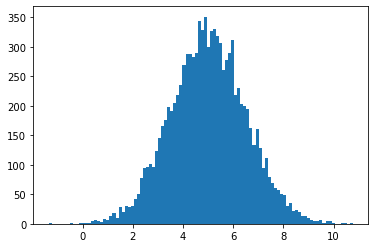

In [152]:
I = 5.00
err = 0.30
N = 10000
MC = I * (1 + err * np.random.standard_normal(N))
f, ax = plt.subplots()
ax.hist(MC, bins=100)
print(np.median(MC*5) / np.std(MC*5), 1/err)

In [214]:
I = 3.0
err = 0.1
obs = pn.Observation()
line = pn.EmissionLine(label='O3_4959A', obsIntens = I*np.ones(10), obsError=err*np.ones(10), corrected = False, errIsRelative=False)
obs.addLine(line)
obs.names = ['N{}N'.format(i) for i in range(obs.n_obs)]
obs.addMonteCarloObs(30)
obs.extinction.E_BV=0.5
obs.correctData()

     addMonteCarloObs: Entering
     addMonteCarloObs: Leaving


In [216]:
med1 = np.median(obs.getIntens(returnObs=True)['O3_4959A'])
std1 = np.std(obs.getIntens(returnObs=True)['O3_4959A'])
med2 = np.median(obs.getIntens(returnObs=False)['O3_4959A'])
std2 = np.std(obs.getIntens(returnObs=False)['O3_4959A'])
print(med1/std1, med2/std2, med1, med2, std1, std2)
print(1./obs.getError(returnObs=True)['O3_4959A'][0])

30.90574137618309 30.905741376183087 2.998528006549826 15.151135172002693 0.09702171418740284 0.49023691059806196
30.0


In [217]:
print(obs.getIntens(returnObs=False)['O3_4959A'] / obs.getIntens(returnObs=True)['O3_4959A'])

[5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765
 5.05285765 5.05285765 5.05285765 5.05285765 5.05285765 5.0528